# DataSets & Libraries Import

In [101]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [102]:
print(test_data)
print(training_data)
print(training_data.data.size())
print(training_data.targets.size())


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


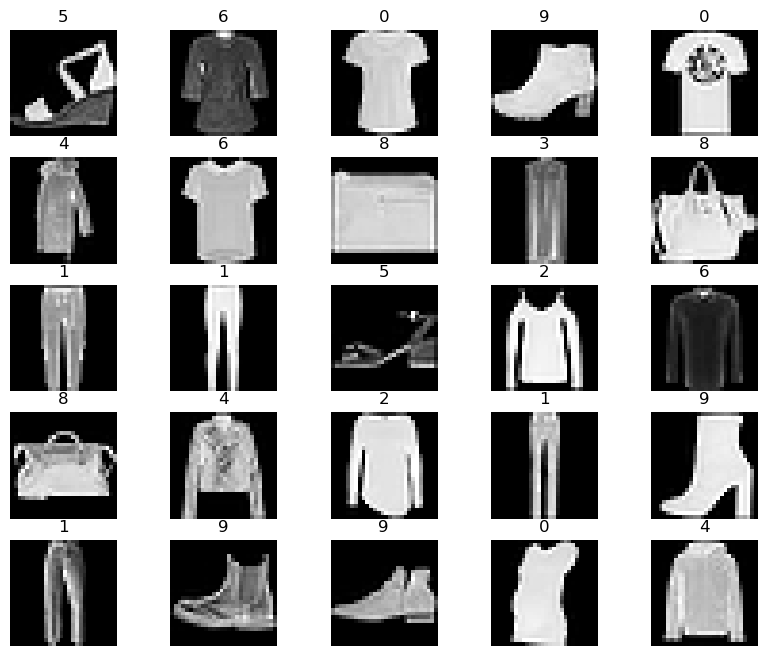

In [103]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# NeuralNetwork Model

In [104]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten() # Flatten inputs
        self.conv_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2, ),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )

        self.output_stack = nn.Sequential(
            nn.Linear(32 * 7 * 7, 10)
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.conv_stack(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        logits = logits.view(logits.size(0), -1)
        logits = self.output_stack(logits)
        return logits

model = BaseNeuralNetwork()

# Functions

In [105]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred,y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Hyperparameters

In [106]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [107]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

# Test

In [108]:
### Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer) #Use train_loop and test_loop functions
    test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298328  [    0/60000]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.349032 

Epoch 2
-------------------------------
loss: 0.289996  [    0/60000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.306415 

Epoch 3
-------------------------------
loss: 0.264590  [    0/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.268793 

Epoch 4
-------------------------------
loss: 0.160629  [    0/60000]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.260194 

Epoch 5
-------------------------------
loss: 0.366721  [    0/60000]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.237382 

Done!
